# Best practices for model evaluation and hyperparameter tuning

Key takeways:
- Split dataset into training, validation, and test set. Use validation set for hyperparameter tuning
- Use cross-validation with 10 folds for medium-sized datasets; increase number of folds for smaller datasets to increase the size of training set
    - In the limit for very small datasets, use k=n: Leave-one-out cross-validation
    - For bigger datasets, 5 is often enough
- Use an sklearn pipeline object to streamline preprocessing & fitting
- You can also use StratifiedKFold to balance the class probabilities in each fold: the label class proportions are preserved in each fold
- Use sklearn's cross_val_score function to easily do k-fold cross validation
- Use sklearn's valdiation_curve function to easily tune a single hyperparameter
- Use GridSearchCV and RandomizedSearchCV for multiple hyperparameter tuning
- Set the class_weight parameter in scikit-learn classifiers to 'balanced' to deal with class inbalances

In [12]:
import pandas as pd 
breast_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
breast_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
from sklearn.preprocessing import LabelEncoder
X = breast_df.loc[:, 2:].values
y = breast_df.loc[:, 1].values 
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [18]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

### Pipeline construction

In [19]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


### Cross-validation: 

In [20]:
from sklearn.model_selection import StratifiedKFold
import numpy as np 
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, Class distr.: {np.bincount(y_train[train])}, Acc.: {score}')
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'10-fold CV accuracy: {mean_acc: .3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.9347826086956522
Fold: 02, Class distr.: [256 153], Acc.: 0.9347826086956522
Fold: 03, Class distr.: [256 153], Acc.: 0.9565217391304348
Fold: 04, Class distr.: [256 153], Acc.: 0.9565217391304348
Fold: 05, Class distr.: [256 153], Acc.: 0.9347826086956522
Fold: 06, Class distr.: [257 153], Acc.: 0.9555555555555556
Fold: 07, Class distr.: [257 153], Acc.: 0.9777777777777777
Fold: 08, Class distr.: [257 153], Acc.: 0.9333333333333333
Fold: 09, Class distr.: [257 153], Acc.: 0.9555555555555556
Fold: 10, Class distr.: [257 153], Acc.: 0.9555555555555556
10-fold CV accuracy:  0.950 +/- 0.014


### Cross-validation using cross_val_score (equivalent to above), and which is PARALLELIZABLE

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)  # choose more jobs to distribute across CPUs, choose -1 to use all CPUs on the machine
print(f'CV accuracy scores: {scores}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


### Assess training set size with learning_curve

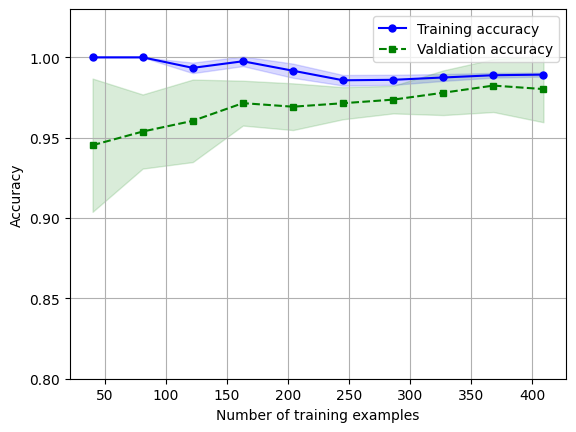

In [25]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',  # is the default
                                           max_iter=10000))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                        cv=10, # uses stratified k-fold cross validation by default
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)  # average over the CV folds
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color="blue", marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color="green", marker='s', markersize=5, label='Valdiation accuracy', linestyle='--')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.ylim([0.8, 1.03])
plt.show()


### Addressing over- and unerfitting with validation curves: hyperparameter tuning

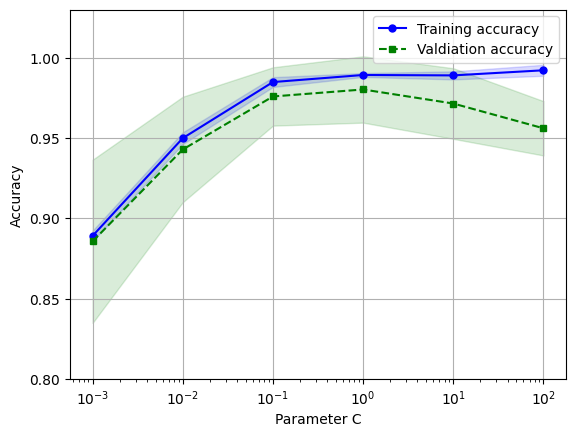

In [35]:
from sklearn.model_selection import validation_curve
param_range = [10.0**l for l in range(-3, 3)]  # possible values for l2-regularizer in logistic regression (C is the inverse of lambda in lambda * w²)
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',  # is the default
                                           max_iter=10000))
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        param_name='logisticregression__C',
                                                        param_range=param_range,
                                                        cv=10, # uses stratified k-fold cross validation by default
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)  # average over the CV folds
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color="blue", marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color="green", marker='s', markersize=5, label='Valdiation accuracy', linestyle='--')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.ylim([0.8, 1.03])
plt.show()


### Finetuning ML algorithms with grid search

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
param_range = [10**exp for exp in range(-4,4)]
param_grid = [{'svc__C': param_range,
                'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,  # this refits the estimator on the best found settings
                  n_jobs=-1)  # run on all processors of this machine (6x speedup on my machine)
gs = gs.fit(X_train, y_train)
print('Best score: ', gs.best_score_)
print('Best params: ', gs.best_params_)

Best score:  0.9846859903381642
Best params:  {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


### Randomized grid search allows to search a distribution over parameters

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC 
import scipy
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
param_range = scipy.stats.loguniform(1e-4,1e4)
param_grid = [{'svc__C': param_range,
                'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel': ['rbf']}]
gs = RandomizedSearchCV(estimator=pipe_svc,
                  param_distributions=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_iter=100,
                  random_state=1,
                  refit=True,  # this refits the estimator on the best found settings
                  n_jobs=-1)  # run on all processors of this machine (6x speedup on my machine)
gs = gs.fit(X_train, y_train)
print('Best score: ', gs.best_score_)
print('Best params: ', gs.best_params_)

Best score:  0.9868599033816425
Best params:  {'svc__C': 8.652852666282676, 'svc__gamma': 0.04103545130983305, 'svc__kernel': 'rbf'}


## PART 2: Looking at different performance metrics

### Confusion matrix

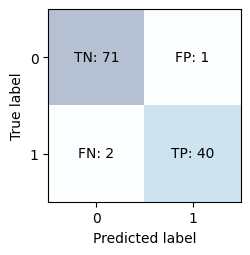

In [64]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5,2.5))
texts = [['TN', 'FP'], 
        ['FN', 'TP']]
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i, s=texts[i][j] + ': '+str(confmat[i,j]), va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

- True Positive Rate (TPR): $\frac{TP}{TP + FN} = 40/42$ = **RECALL** OR **SENSITIVITY**: proportion of true positives that is predicted as postive
- False Positive Rate (FPR): $\frac{FP}{FP+TN} = 1/72$: proportion of negatives that is predicted as positive
- True Negative Rate (TNR): $\frac{TN}{TN+FP}$: proportion of negatives that is predicted as negative
- False Negative Rate (FNR): $\frac{FN}{FN + TP}$: proportion of negatives that is predicted as positive
- **PRECISION**: $\frac{TP}{TP+FP}$: proportion of those predicted as postive that are really positive
- F1-score: harmonic mean of precision and recall: $F1 = 2*\frac{PRE\times REC}{PRE+REC}$

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('f1: ', f1_score(y_test, y_pred))
pre = precision_score(y_test, y_pred)
print('precision: ', pre)
rec = recall_score(y_test, y_pred)
print('recall: ', rec)
print('harmonic mean: ', 2 * (pre*rec)/(pre+rec))

f1:  0.963855421686747
precision:  0.975609756097561
recall:  0.9523809523809523
harmonic mean:  0.963855421686747


### ROC curve

The Receiver Operating Characterstic can be used to assess the quality of a binary classifier by comparing the True Positive Rate as a function of the False Positive Rate when the following decision rule is used: $$\hat{y}_\tau(\pmb{x}) = \mathbb{I}(p(y=1|\pmb{x})>\tau)$$ The TPR and FPR measure the proportion of predicted positives to the true total amount of postives and negatives respectively. By increasing the threshold $\tau$, the TPR will decrease since less examples will be classified as positive. However those might become false positives and therefore the FPR will increase. Thus the TPR is a function of the FPR and this relationship can be nicely visualized in the ROC curve. The area under this curve might be used as an estimate of the overall quality of the classifer.

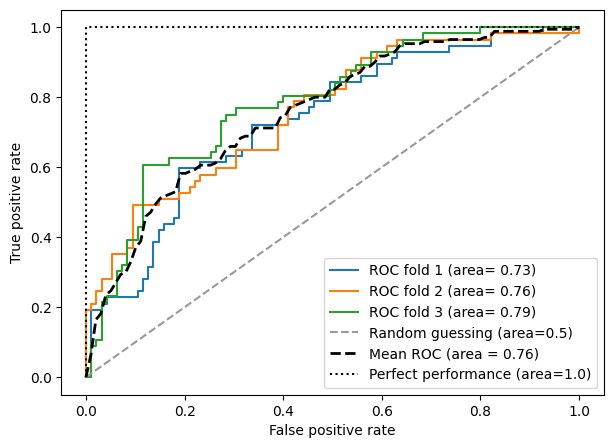

In [70]:
from sklearn.metrics import roc_curve, auc 
from numpy import interp 
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2', random_state=1,
                       solver='lbfgs', C=100.0)
)
X_train2 = X_train[:, [4,14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0 
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test]) # proba will contain the probs (for each example) p(y=1|x) en p(y=0|x) which sum to 1
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)  # the 1 in proba refers to p(y=1|x), where 0 would refer to p(y=0|x)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area= {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
mean_tpr /=len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1], [0,1,1], linestyle=':', color='black', label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc='lower right')
plt.show()
